<h2>Functions</h2>

In [1]:
# Functional imports
import os 
import numpy as np
import nibabel as nib
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split

from data_prep_helpers import make_vol
from plotting_helpers import plot_lateral_only, plot_lateral_only_with_vmax

# Notebook specific imports
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
%autosave 5


Bad key text.latex.preview in file /opt/miniconda3/envs/mybrainiak/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/miniconda3/envs/mybrainiak/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/miniconda3/envs/mybrainiak/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg i

Autosaving every 5 seconds


In [2]:
def calculate_difference(group1, group2):
    """
    Calculate the difference in mean R values at each voxel between two groups.
    Input: 2 groups' raw, unthresholded R values (subject x voxel array)
    Returns: group 1 average - group2 average (array of len n_voxels)
    """
    return np.subtract(np.mean(group1, axis=0), np.mean(group2, axis=0))

def generate_null_comparison(group1, group2, n_permutations):
    """
        Generates a null distribution of inter-group differences via permutation test. 
        Returns a null distribution of dim n_voxels x n_permutations
    """
    all_subjects = np.vstack((group1, group2))
    null_dist = []
    for i in range(n_permutations):
        # Split data randomly
        sample_group1, sample_group2 = train_test_split(all_subjects, train_size=len(group1), test_size=len(group2))

        # Calculate difference in means
        null_dist.append(calculate_difference(sample_group1, sample_group2))
    return np.swapaxes(null_dist, 0, 1)

def get_p_values(observed, null_dist):
    """
        Generates one-tailed p-value for each score relative to the null distribution
        Assumes null_dist takes the shape [n_voxels, n_iterations] 
    """
    p_vals = []
    num_iterations = np.shape(null_dist)[1]
    
    for i in range(len(observed)):
        
        # Extract relevant distribution from overall data
        observed_score = observed[i]
        null_scores = null_dist[i]
        
        # Get number of values greater than observed_score
        more_extreme_count = len(np.where(null_scores >= observed_score)[0])
        
        # Calculate p-value
        p_val = (more_extreme_count + 1) / (num_iterations + 1)
        
        # Store p-value
        p_vals.append(p_val)
        
    return p_vals

def get_fdr_controlled(p, threshold, observed):
    """
        Given a set of p values for each voxel and a threshold, applies FDR correction
        Returns number of significant voxels and array with only significant voxels retained
    """
    # Make changes to a copy of the original array
    thresholded_voxels = np.copy(observed)

    # Generate fdr corrected p values (i,e q values)
    q = multipletests(p, method='fdr_bh')[1]

    # Mask insignificant voxels out with NaNs
    thresholded_voxels[q >= threshold] = np.nan

    # Calculate the number of significant voxels
    num_significant_voxels = np.sum(q < threshold)

    return thresholded_voxels, num_significant_voxels



<h2>Load data</h2>

In [3]:
# Set data location
directory = os.path.join(os.path.expanduser('~'), 'Documents', 'Data')
print('Data location:', directory)

# Load mask
mask = nib.load(os.path.join(directory, 'group_gm_mask.nii.gz'))
print('Mask shape:', np.shape(mask))

Data location: /Users/angira/Documents/Data
Mask shape: (79, 95, 68)


<h3>Adults</h3>

In [4]:
full_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_full_scores_gm_mask.npy'))
social_only_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_social_only_scores_gm_mask.npy'))
print('Raw scores shape:', np.shape(full_adults))

Raw scores shape: (33, 367709)


<h3>3-4 years</h3>

In [5]:
full_34yrs = np.load(os.path.join(
    directory, '3-4-yrs', 'encoding_results', 'unthresholded', '3-4-yrs_full_scores_gm_mask.npy'))
social_only_34yrs = np.load(os.path.join(
    directory, '3-4-yrs', 'encoding_results', 'unthresholded', '3-4-yrs_social_only_scores_gm_mask.npy'))
print('Raw scores shape:', np.shape(full_34yrs))

Raw scores shape: (31, 367709)


<h3>5 years</h3>

In [6]:
full_5yrs = np.load(os.path.join(
    directory, '5-yrs','encoding_results', 'unthresholded', '5-yrs_full_scores_gm_mask.npy'))
social_only_5yrs = np.load(os.path.join(
    directory, '5-yrs','encoding_results', 'unthresholded', '5-yrs_social_only_scores_gm_mask.npy'))

<h3>7 years</h3>

In [7]:
full_7yrs = np.load(os.path.join(
    directory, '7-yrs', 'encoding_results', 'unthresholded', '7-yrs_full_scores_gm_mask.npy'))
social_only_7yrs = np.load(os.path.join(
    directory, '7-yrs', 'encoding_results', 'unthresholded', '7-yrs_social_only_scores_gm_mask.npy'))

<h3>8-12 years</h3>

In [8]:
full_812yrs = np.load(os.path.join(
    directory, '8-12-yrs','encoding_results', 'unthresholded', '8-12-yrs_full_scores_gm_mask.npy'))
social_only_812yrs = np.load(os.path.join(
    directory, '8-12-yrs','encoding_results', 'unthresholded', '8-12-yrs_social_only_scores_gm_mask.npy'))

<h2>Calculate differences</h2>

In [11]:
social_diff_34yrs = calculate_difference(social_only_adults, social_only_34yrs)
np.save(os.path.join(directory, 'encoding_differences', '3-4-yrs_social_difference.npy'), social_diff_34yrs)
print('Saved 3-4 years'), 
social_diff_5yrs = calculate_difference(social_only_adults, social_only_5yrs)
np.save(os.path.join(directory, 'encoding_differences', '5-yrs_social_difference.npy'), social_diff_5yrs)
print('Saved 5 years')
social_diff_7yrs = calculate_difference(social_only_adults, social_only_7yrs)
np.save(os.path.join(directory, 'encoding_differences', '7-yrs_social_difference.npy'), social_diff_7yrs)
print('Saved 7 years')
social_diff_812yrs = calculate_difference(social_only_adults, social_only_812yrs)
np.save(os.path.join(directory, 'encoding_differences', '8-12-yrs_social_difference.npy'), social_diff_812yrs)
print('Saved 8-12 years')

Saved 3-4 years
Saved 5 years
Saved 7 years
Saved 8-12 years


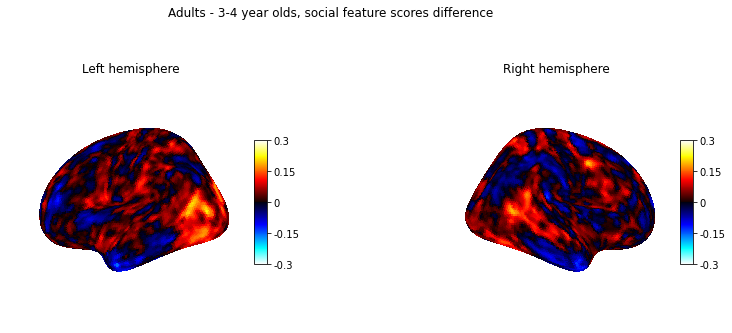

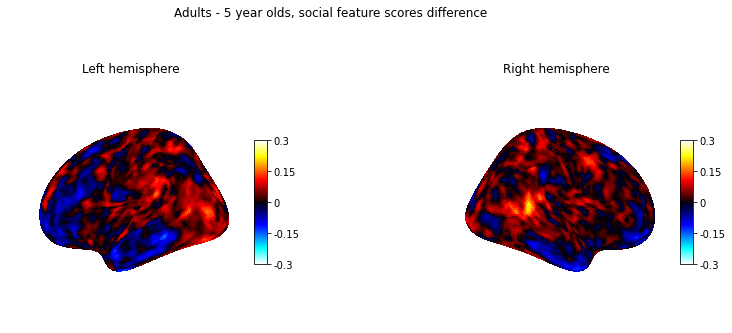

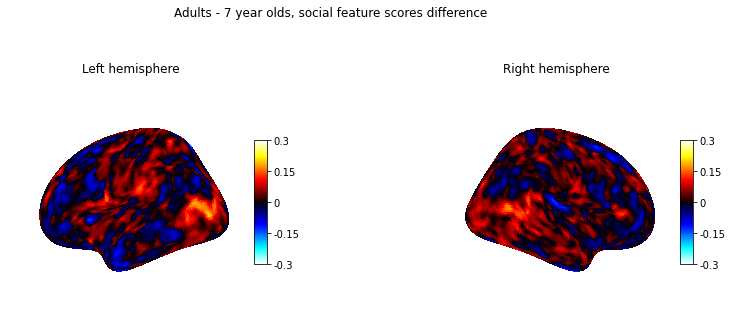

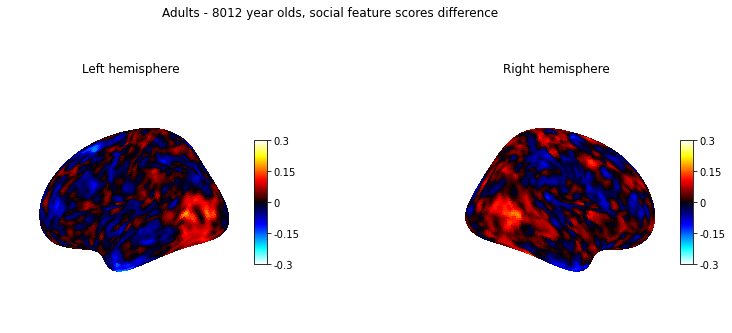

In [12]:
plot_lateral_only_with_vmax(vol=make_vol(social_diff_34yrs, mask), 
                            title='Adults - 3-4 year olds, social feature scores difference', 
                            vis_threshold=0.0, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_5yrs, mask), 
                            title='Adults - 5 year olds, social feature scores difference', 
                            vis_threshold=0.0, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_7yrs, mask), 
                            title='Adults - 7 year olds, social feature scores difference', 
                            vis_threshold=0.0, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_812yrs, mask), 
                            title='Adults - 8012 year olds, social feature scores difference', 
                            vis_threshold=0.0, vmax=0.3)

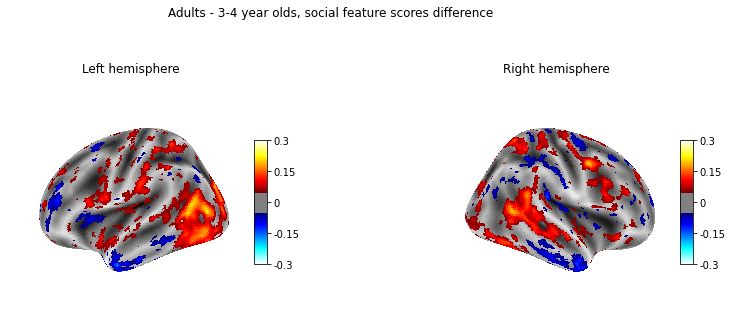

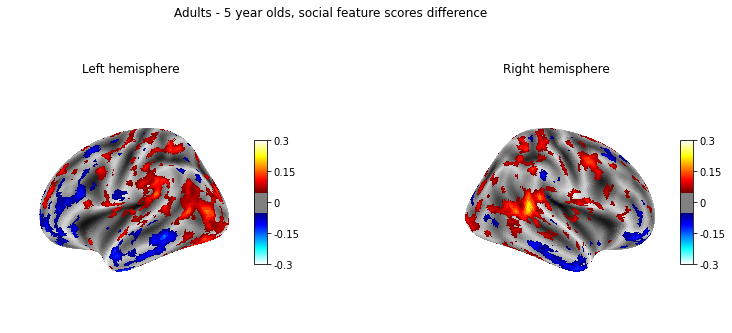

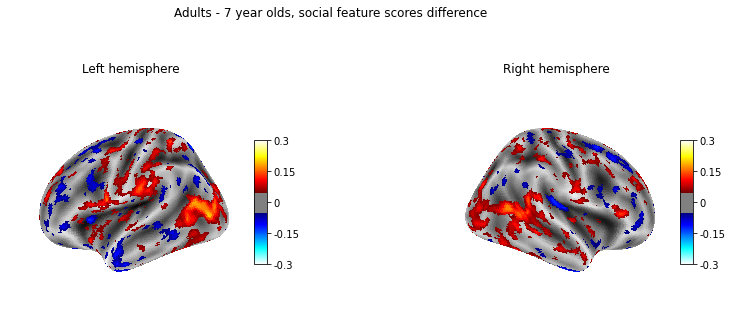

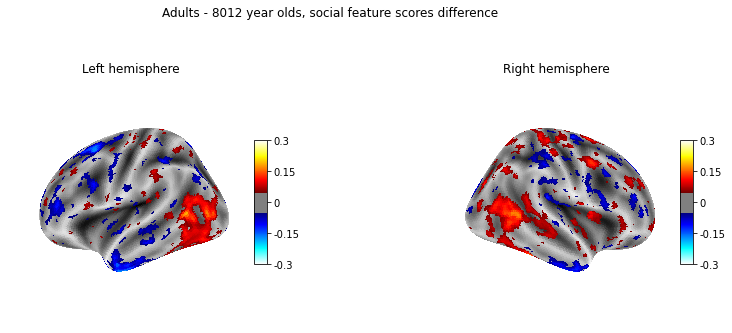

In [13]:
plot_lateral_only_with_vmax(vol=make_vol(social_diff_34yrs, mask), 
                            title='Adults - 3-4 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_5yrs, mask), 
                            title='Adults - 5 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_7yrs, mask), 
                            title='Adults - 7 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)

plot_lateral_only_with_vmax(vol=make_vol(social_diff_812yrs, mask), 
                            title='Adults - 8012 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)

<h2>Threshold differences using group permutation</h2>

In [5]:
social_only_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_social_only_scores_gm_mask.npy'))

<h3>3-4 year olds</h3>

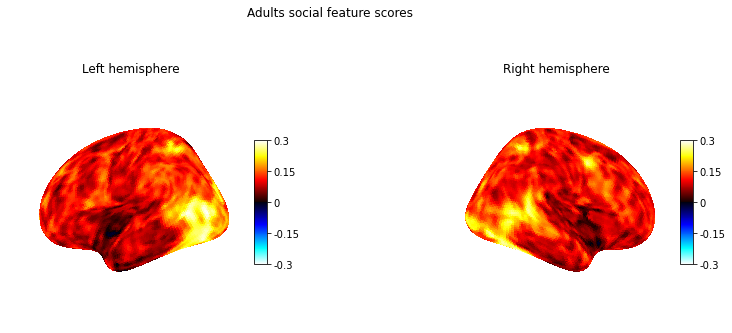

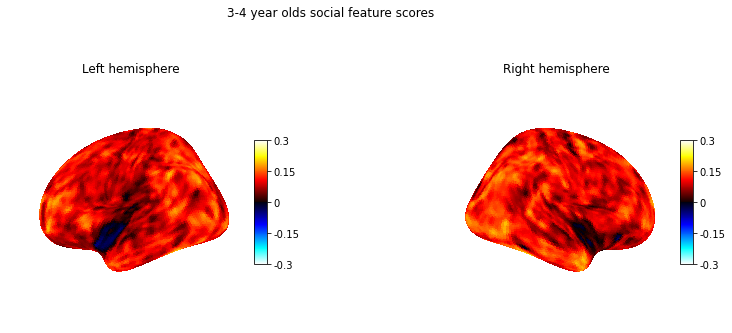

In [ ]:
social_only_34yrs = np.load(os.path.join(
    directory, '3-4-yrs', 'encoding_results', 'unthresholded', '3-4-yrs_social_only_scores_gm_mask.npy'))
social_diff_34yrs = calculate_difference(social_only_adults, social_only_34yrs)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_adults, axis=0), mask), 
                            title='Adults social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_34yrs, axis=0), mask), 
                            title='3-4 year olds social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(social_diff_34yrs, mask), 
                            title='Adults - 3-4 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)


In [7]:
social_null_comparison_34yrs = generate_null_comparison(group1=social_only_adults, 
                                                        group2=social_only_34yrs, 
                                                        n_permutations=5000)
print('Null distribution:', np.shape(social_null_comparison_34yrs))

social_p_34yrs = get_p_values(observed=social_diff_34yrs, null_dist=social_null_comparison_34yrs)
print('p values:', np.shape(social_p_34yrs))

Null distribution: (367709, 5000)
p values: (367709,)


In [8]:
social_thresholded_34yrs, social_sig_34yrs = get_fdr_controlled(p=social_p_34yrs, 
                                                                threshold=0.05, 
                                                                observed=social_diff_34yrs)
print(social_sig_34yrs, 'significant voxels at threshold p < 0.05')

0 significant voxels at threshold p < 0.05


<h3>5 year olds</h3>

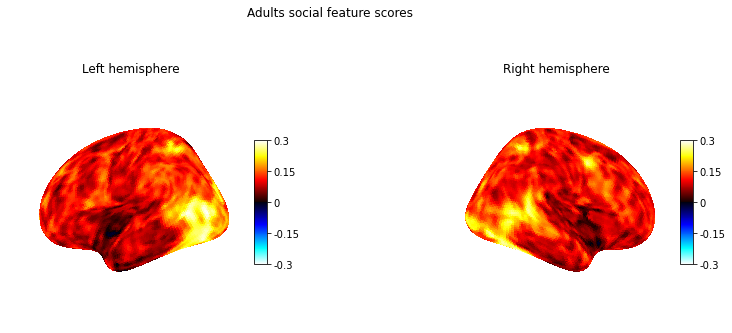

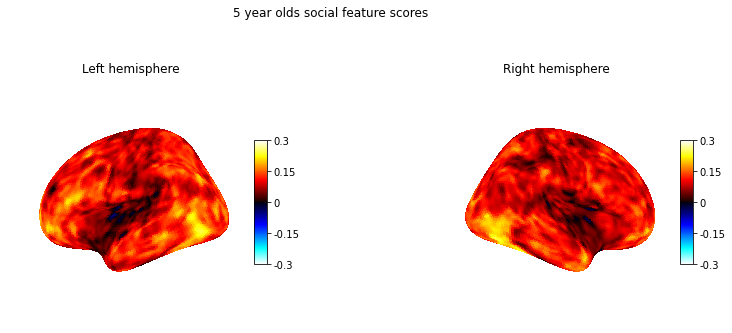

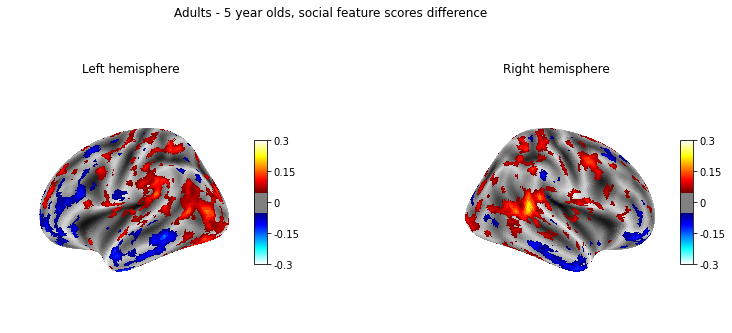

In [10]:
social_only_5yrs = np.load(os.path.join(
    directory, '5-yrs', 'encoding_results', 'unthresholded', '5-yrs_social_only_scores_gm_mask.npy'))
social_diff_5yrs = calculate_difference(social_only_adults, social_only_5yrs)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_adults, axis=0), mask), 
                            title='Adults social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_5yrs, axis=0), mask), 
                            title='5 year olds social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(social_diff_5yrs, mask), 
                            title='Adults - 5 year olds, social feature scores difference', 
                            vis_threshold=0.05, vmax=0.3)

In [11]:
social_null_comparison_5yrs = generate_null_comparison(group1=social_only_adults, 
                                                       group2=social_only_5yrs, 
                                                       n_permutations=5000)
print('Null distribution:', np.shape(social_null_comparison_5yrs))

social_p_5yrs = get_p_values(observed=social_diff_5yrs, null_dist=social_null_comparison_5yrs)
print('p values:', np.shape(social_p_5yrs))

Null distribution: (367709, 5000)
p values: (367709,)


In [13]:
social_thresholded_5yrs, social_sig_5yrs = get_fdr_controlled(p=social_p_5yrs, 
                                                              threshold=0.05, 
                                                              observed=social_diff_5yrs)
print(social_sig_5yrs, 'significant voxels at threshold p < 0.05')

0 significant voxels at threshold p < 0.05


<h3>7 year olds</h3>

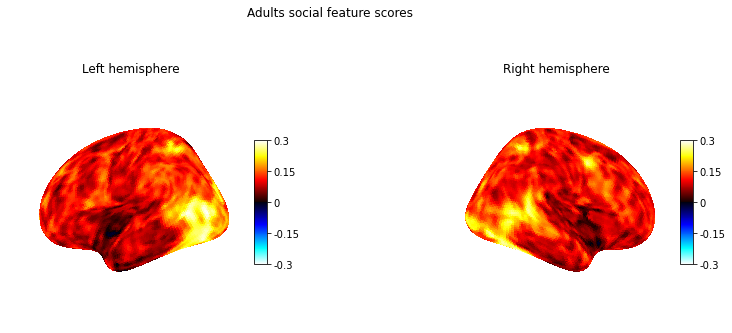

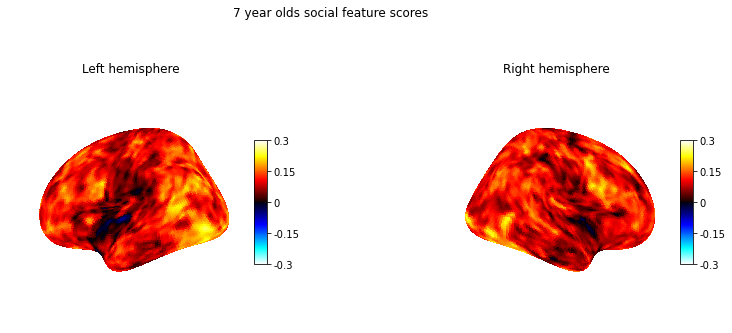

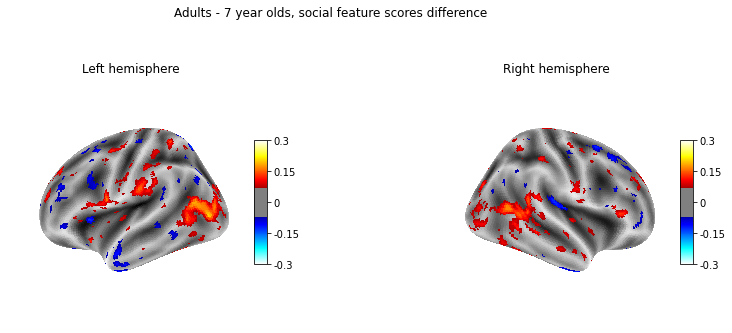

In [7]:
social_only_7yrs = np.load(os.path.join(
    directory, '7-yrs', 'encoding_results', 'unthresholded', '7-yrs_social_only_scores_gm_mask.npy'))
social_diff_7yrs = calculate_difference(social_only_adults, social_only_7yrs)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_adults, axis=0), mask), 
                            title='Adults social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_7yrs, axis=0), mask), 
                            title='7 year olds social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(social_diff_7yrs, mask), 
                            title='Adults - 7 year olds, social feature scores difference', 
                            vis_threshold=0.07, vmax=0.3)

In [8]:
social_null_comparison_7yrs = generate_null_comparison(group1=social_only_adults, 
                                                       group2=social_only_7yrs, 
                                                       n_permutations=5000)
print('Null distribution:', np.shape(social_null_comparison_7yrs))

social_p_7yrs = get_p_values(observed=social_diff_7yrs, null_dist=social_null_comparison_7yrs)
print('p values:', np.shape(social_p_7yrs))

Null distribution: (367709, 5000)
p values: (367709,)


In [9]:
social_thresholded_7yrs, social_sig_7yrs = get_fdr_controlled(p=social_p_7yrs, 
                                                              threshold=0.05, 
                                                              observed=social_diff_7yrs)
print(social_sig_7yrs, 'significant voxels at threshold p < 0.05')

0 significant voxels at threshold p < 0.05


<h3>8-12 years</h3>

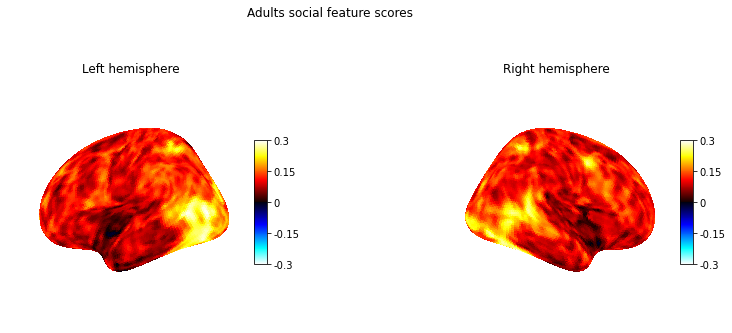

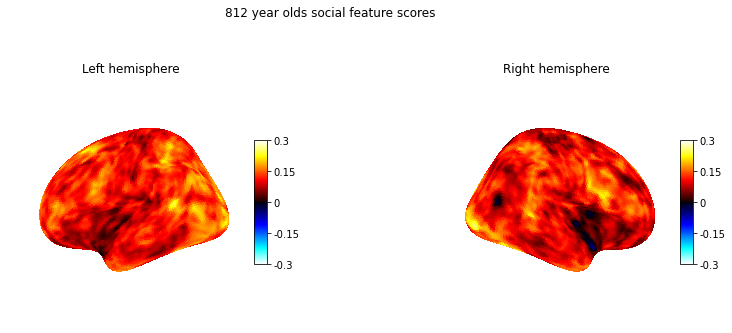

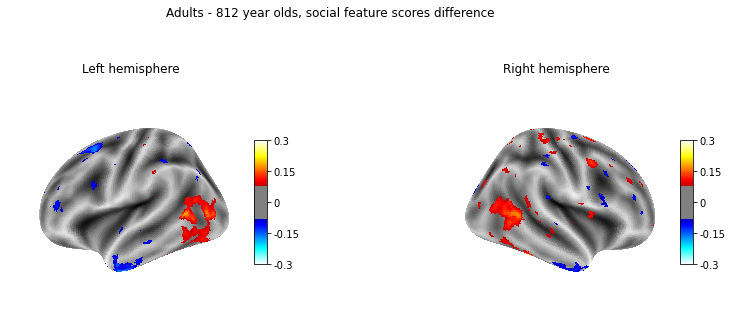

In [10]:
social_only_812yrs = np.load(os.path.join(
    directory, '8-12-yrs', 'encoding_results', 'unthresholded', '8-12-yrs_social_only_scores_gm_mask.npy'))
social_diff_812yrs = calculate_difference(social_only_adults, social_only_812yrs)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_adults, axis=0), mask), 
                            title='Adults social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(np.mean(social_only_812yrs, axis=0), mask), 
                            title='812 year olds social feature scores', 
                            vis_threshold=0.0, vmax=0.3)
plot_lateral_only_with_vmax(vol=make_vol(social_diff_812yrs, mask), 
                            title='Adults - 812 year olds, social feature scores difference', 
                            vis_threshold=0.0812, vmax=0.3)

In [11]:
social_null_comparison_812yrs = generate_null_comparison(group1=social_only_adults, 
                                                       group2=social_only_812yrs, 
                                                       n_permutations=5000)
print('Null distribution:', np.shape(social_null_comparison_812yrs))

social_p_812yrs = get_p_values(observed=social_diff_812yrs, null_dist=social_null_comparison_812yrs)
print('p values:', np.shape(social_p_812yrs))

Null distribution: (367709, 5000)
p values: (367709,)


In [12]:
social_thresholded_812yrs, social_sig_812yrs = get_fdr_controlled(p=social_p_812yrs, 
                                                                 threshold=0.05, 
                                                                 observed=social_diff_812yrs)
print(social_sig_812yrs, 'significant voxels at threshold p < 0.05')

0 significant voxels at threshold p < 0.05
